# Run Tesseract on the DexRay algorithm

In [32]:
# Standard library imports
import argparse
import csv
import datetime
import os
import random as python_random
import sys
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tqdm import tqdm

# Optional import (commented)
# import tensorflow_addons as tfa

# Local imports
from tesseract import evaluation, metrics, mock, temporal, spatial


random_seed = 123456

In [28]:
APK_METADATA_PATH = "/scratch/users/mbenali/metadata.csv"

GOODWARE_PATH = "/scratch/users/mbenali/download_apk/images/goodware"
MALWARE_PATH = "/scratch/users/mbenali/download_apk/images/malware"

IMG_SIZE=128

### Time Plots

The first plot shows the distribution of all 10000 APKs.

Helper function `load_images()` to load and preprocess the grayscale images into a numpy array X

In [ ]:
def extract_dates_from_csv():
    # List to hold the date objects
    date_list = []
    
    # Open and read the CSV file
    with open(APK_METADATA_PATH) as csvfile:
        reader = csv.reader(csvfile)
        next(reader)  # Skip the header row
        for row in reader:
            # Convert the string from the 4th column to a datetime object
            try:
                date = datetime.strptime(row[3], '%Y-%m-%d %H:%M:%S')
                date_list.append(date)
            except ValueError:
                # Handle invalid date format if necessary
                pass
    
    # Convert the list of datetime objects to a numpy array
    return np.array(date_list)

<class 'numpy.ndarray'>


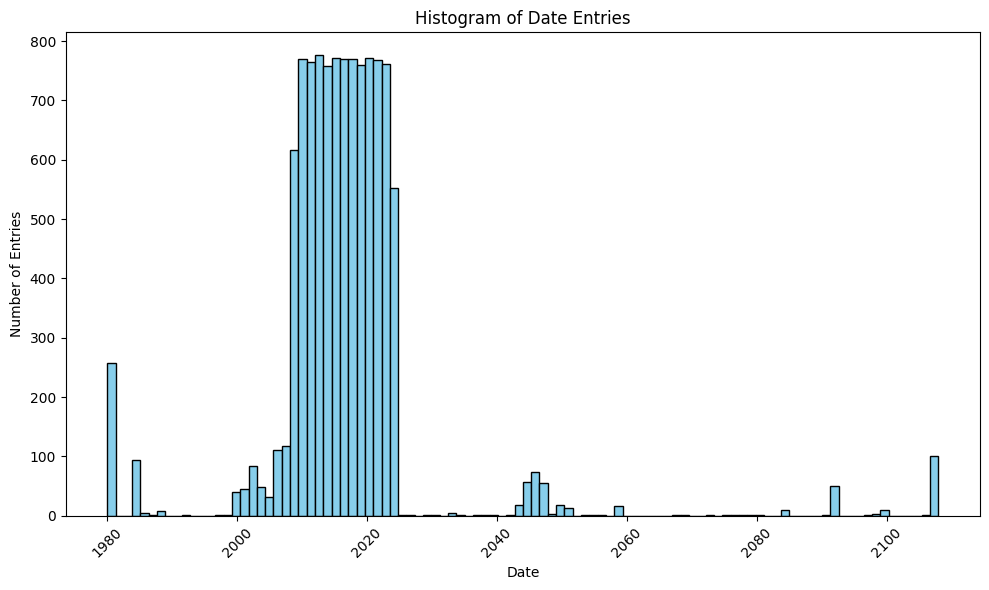

In [4]:
dates = extract_dates_from_csv()

plt.figure(figsize=(10, 6))
plt.hist(dates, bins=100, edgecolor='black', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Histogram of Date Entries')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

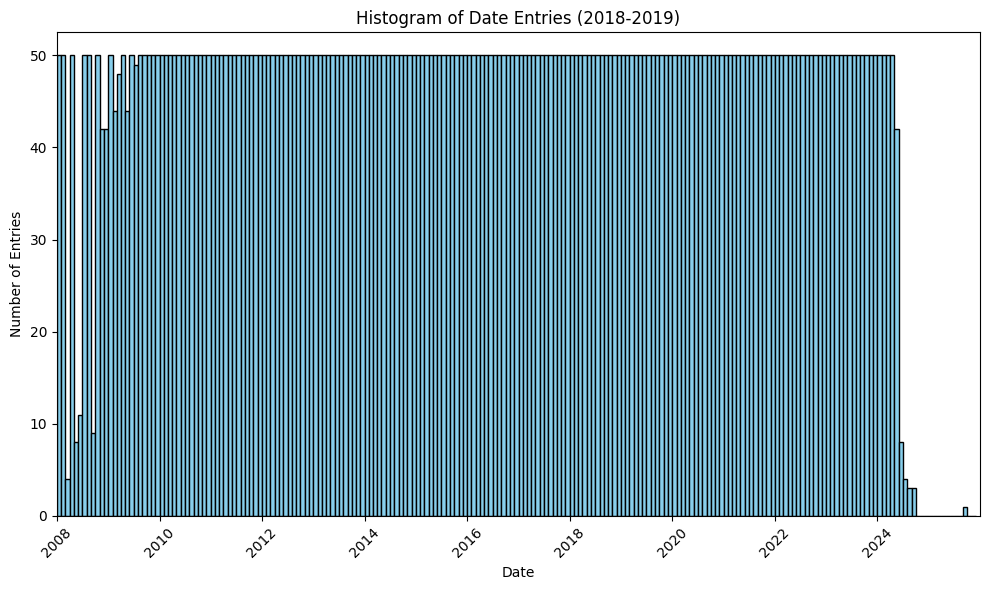

In [5]:
# Define the start and end date for the x-axis
start_date = datetime(2008, 1, 1)
end_date = datetime(2025, 12, 31, 23, 59, 59)

# Generate the bin edges (start of each month between 2018 and 2019)
bins = []
current_date = start_date
while current_date <= end_date:
    bins.append(current_date)
    # Move to the start of the next month
    next_month = current_date.replace(day=28) + timedelta(days=4)  # Move to next month's first day
    current_date = next_month.replace(day=1)

# Plot the histogram with bins representing one month
plt.figure(figsize=(10, 6))
plt.hist(dates, bins=bins, edgecolor='black', color='skyblue')

# Set x-axis limits to the range from 2018-01-01 to 2019-12-31
plt.xlim(start_date, end_date)

# Label the axes and title
plt.xlabel('Date')
plt.ylabel('Number of Entries')
plt.title('Histogram of Date Entries (2018-2019)')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Auto adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()

### Extract X, y and temp

In [38]:
def get_date_time_from_hash(search_hash):
    """
    Retrieves the `dex_date` for the given hash and formats it as a timestamp.
    
    Args:
        file_path (str): Path to the CSV file.
        search_hash (str): The hash to search for.
    
    Returns:
        datetime: The formatted timestamp or None if the hash is not found.
    """
    with open(APK_METADATA_PATH, 'r') as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=[
            'sha256', 'sha1', 'md5', 'date_time', 'number1',
            'package', 'number2', 'number3', 'dex_date', 'number4', 'source'
        ])
        print(f"Getting date for: {search_hash}")
        for row in reader:
            if row['sha256'] == search_hash:
                try:
                    # Convert dex_date to the required format
                    timestamp = datetime.strptime(row['dex_date'], '%Y-%m-%d %H:%M:%S')
                    print("Got date")
                    return timestamp
                except ValueError as e:
                    print(f"Error parsing date: {e}")
                    return None
    return None

# Example usage:
search_hash = "0000090C2169EFF7E9A889CA1953CF39C887E0FD23A9BEF6E44A387339842C40"
timestamp = get_date_time_from_hash(search_hash)
print(f"Timestamp: {timestamp}")

Getting date for: 0000090C2169EFF7E9A889CA1953CF39C887E0FD23A9BEF6E44A387339842C40
Got date
Timestamp: 2016-05-19 18:52:41


In [ ]:
def load_images(
    image_dir: str, image_size=(IMG_SIZE, IMG_SIZE)
):
    """
    Load and preprocess grayscale images from a directory into a numpy array,
    flattening each image into a one-dimensional array.

    Args:
        directory_path (str): Path to the directory containing .png images.
        image_size (tuple): Tuple specifying the desired size (width, height).

    Returns:
        np.ndarray: A 2D array where each row is a flattened image (num_images, num_pixels).
    """
    images = [] # X, array containing all images 
    labels = [] # y, array containing which class the image belongs to
    temp = [] # temp, array for all dates (temp)

    for file_name in sorted(os.listdir(image_dir)):  # Ensure reproducible order
        
        if not file_name.endswith('.png'):
            continue
        
        img_path = os.path.join(image_dir, file_name)
        img = Image.open(img_path).convert('L')  # Convert to grayscale
        img = img.resize(image_size)  # Resize to uniform size
        img_array = np.array(img).flatten()  # Convert to numpy array and flatten
        img_array = img_array[:, np.newaxis]  # Add a new axis for shape (num_pixels, 1)
        images.append(img_array)

        labels.append(0) if 'goodware' in image_dir else labels.append(1)
        
        apk_date = get_date_time_from_hash(file_name[:-4]) # might need to change to [:-8] to ignore .apk.png
        temp.append(apk_date)

    return np.stack(images), np.array(labels), np.array(temp)

Starting here, I don't know the code and I didn't touch anything until the next section.

In [8]:
import os
import numpy as np
from PIL import Image
from concurrent.futures import ProcessPoolExecutor

def process_image(file_info):
    file_name, image_dir, image_size, output_dir = file_info
    img_path = os.path.join(image_dir, file_name)
    
    # Process the image
    img = Image.open(img_path).convert('L')  # Convert to grayscale
    img = img.resize(image_size)  # Resize to uniform size
    img_array = np.array(img).flatten()  # Convert to numpy array and flatten
   # label = 0 if 'goodware' in image_dir else 1
   # apk_date = get_date_time_from_hash(file_name[:-4])  # Adjust index if needed

    # Save the processed image
    output_image_path = os.path.join(output_dir, f"{file_name[:-4]}.npy")
    np.save(output_image_path, img_array)
    
    # Return metadata (label and date)
    # return file_name #, label, apk_date

def load_images(image_dir: str, output_dir: str, image_size=(IMG_SIZE, IMG_SIZE)):
    os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist
    
    files = [
        (file_name, image_dir, image_size, output_dir)
        for file_name in sorted(os.listdir(image_dir))
        if file_name.endswith('.png')
    ]
    
    # Filter out already processed files
    files_to_process = [
        file for file in files
        if not os.path.exists(os.path.join(output_dir, f"{file[0][:-4]}.npy"))
    ]
    print(f"files: { len(files)}")
    print(f"files to process: {len(files_to_process)}")
    # Process images in parallel
    with ProcessPoolExecutor(8) as executor:
       list(executor.map(process_image, files_to_process))


In [ ]:
load_images(MALWARE_PATH,"./npy/malware",(IMG_SIZE, IMG_SIZE))

files: 2123
files to process: 1755


In [ ]:
X1, l1, t1 = load_images(MALWARE_PATH)
np.save('malware_X.npy', X1)  # Save images
np.save('malware_labels.npy', l1)  # Save labels
np.save('malware_dates.npy', t1)  # Save dateso
print("ended with malware arrays")

### Load X, y and temp

Here starts the new code getting X from the numpy files, y from the folder name and getting the corresponding date by searching the CSV.

In [68]:
def load_apk_metadata(file_path):
    """Loads the APK metadata from the CSV file into a dictionary for quick lookups."""
    metadata = {}
    with open(file_path, 'r') as csv_file:
        reader = csv.DictReader(csv_file, fieldnames=[
            'sha256', 'sha1', 'md5', 'date_time', 'number1',
            'package', 'number2', 'number3', 'dex_date', 'number4', 'source'
        ])
        csv_file.seek(0)  # Reset file pointer to the beginning
        for row in reader:
            metadata[row['sha256']] = row['dex_date']
    return metadata

def get_date_time_from_hash(search_hash, metadata):
    """
    Retrieves the `dex_date` for the given hash using preloaded metadata."""
    if search_hash in metadata:
        try:
            return datetime.strptime(metadata[search_hash], '%Y-%m-%d %H:%M:%S')
        except ValueError as e:
            print(f"Error parsing date for {search_hash}: {e}")
            return None
    return None

In [46]:
metadata = load_apk_metadata(APK_METADATA_PATH)

In [47]:
len(metadata)

24792509

In [83]:
NUMPY_FILES_DIR = "/scratch/users/mbenali/download_apk/npy"
# Define timeframe of relevant apps 
YEAR_START = 2010
YEAR_END = 2022

def assemble_arrays():
    """Assembles numpy arrays from .npy files along with their labels and dates."""
    X = []
    y = []
    temp = []

    dirs = [NUMPY_FILES_DIR + '/goodware', NUMPY_FILES_DIR + '/malware']
    stop = 0

    for directory in dirs:
        if not os.path.exists(directory):
            continue
            
        for file in os.listdir(directory):
            if stop >= 10000:
                break
            stop += 1

            if not file.endswith('.npy'):
                continue

            # Obtain the date
            apk_date = get_date_time_from_hash(file[:-4], metadata)  # remove .npy

            # Do not include if outside of date range
            if apk_date is None or apk_date.year < YEAR_START or apk_date.year > YEAR_END:
                continue

            temp.append(apk_date)

            filepath = os.path.join(directory, file)
            array = np.load(filepath)
            X.append(array.flatten())  # Flattening ensures all arrays are rows

            # Obtain the label 
            y.append(0 if 'goodware' in directory else 1)

        print(f"Done with {directory}")

    return np.stack(X), np.array(y), np.array(temp)

In [84]:
X, y, temp = assemble_arrays()

Done with /scratch/users/mbenali/download_apk/npy/goodware
Done with /scratch/users/mbenali/download_apk/npy/malware


In [110]:
# Get all sorts of sanity checks
print(f"Shape of X: {X.shape}")

print(f"\n# elements in y: {len(y)}")
print(f"# of unique elements in y (0, 1): {np.unique(y)}")
print(f"# of malware samples: {len(y[y == 1])}")
print(f"# of goodware samples: {len(y[y == 0])}")

print(f"\n# elements in temp: {len(temp)}")

Shape of X: (9049, 16384)

# elements in y: 9049
# of unique elements in y (0, 1): [0 1]
# of malware samples: 1196
# of goodware samples: 7853

# elements in temp: 9049


### Create DexRay Model with Keras

In [124]:
model_architecture = Sequential()
model_architecture.add(
    Conv1D(
        filters=64,
        kernel_size=12,
        activation="relu",
        input_shape=(IMG_SIZE * IMG_SIZE, 1),
    )
)
model_architecture.add(MaxPooling1D(pool_size=12))
model_architecture.add(Conv1D(filters=128, kernel_size=12, activation="relu"))
model_architecture.add(MaxPooling1D(pool_size=12))
model_architecture.add(Flatten())
model_architecture.add(Dense(64, activation="sigmoid"))
model_architecture.add(Dense(1, activation="sigmoid"))

model = keras.models.clone_model(model_architecture)
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.BinaryCrossentropy(),
)

### Tesseract

Split the data with Tesseract's `time_aware_train_test_split`

In [125]:
splits = temporal.time_aware_train_test_split(
    X, y, temp, train_size=96, test_size=2, granularity='month'
)
X_train, X_test, y_train, y_test, t_train, t_test = splits

print(f"X_train: {X_train.shape}") # Sanity Check
print(f"X_test: {len(X_test)}") # Sanity Check

X_train: (6205, 16384)
X_test: 21


In [126]:
# Downsample so that there's the requested percentage of malware in the training data
train_idxs = spatial.downsample_to_rate(y_train, 0.70)

X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
temp_train = t_train[train_idxs]

print(f"# of malware samples: {len(y_train[y_train == 1])}")
print(f"# of goodware samples: {len(y_train[y_train == 0])}")


# of malware samples: 754
# of goodware samples: 323


In [127]:
results = evaluation.fit_predict_update(model, *splits)

5/5 [==============================] - 0s 24ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




6/6 [==============================] - 0s 26ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




1/3 [=========>....................] - ETA: 0s

/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [==============================] - 0s 19ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




5/5 [==============================] - 0s 24ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




9/9 [==============================] - 0s 27ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




4/4 [==============================] - 0s 27ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




3/3 [==============================] - 0s 16ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




3/3 [==============================] - 0s 17ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




1/3 [=========>....................] - ETA: 0s

/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [==============================] - 0s 17ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




3/3 [==============================] - 0s 25ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




3/3 [==============================] - 0s 18ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




9/9 [==============================] - 0s 25ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




17/17 [==============================] - 0s 26ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




6/6 [==============================] - 0s 27ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




4/4 [==============================] - 0s 21ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




1/3 [=========>....................] - ETA: 0s

/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


3/3 [==============================] - 0s 22ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




7/7 [==============================] - 0s 23ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




1/1 [==============================] - 0s 31ms/step


/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))




In [128]:
metrics.print_metrics(results)

------------+---------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21   
------------+---------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |     19     39     11     23     39     16     16      8      6      9     18     16     10     25     66     41     10      7     32     29      2
Actual neg  |    122    135     35     52    107    265    111     60     63     45     53     73     64    244    455    147     92     45     49    169     16
Total       |    141    174     46     75    146    281    127     68     69     54     71     89     74    269    521    188    102     52     81    198     18
------------+-------------------